<a href="https://colab.research.google.com/github/NehaNeha417/DL_SHALA/blob/master/Multiclass_classification_A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Embedding,LSTM          # spatialDropoutID
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
file = ('drive/My Drive/Data_DL/uci-news-aggregator.csv')
data = pd.read_csv(file)

In [16]:
data.shape

(422419, 8)

In [17]:
data.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [18]:
data.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

In [19]:
num_of_categories = 45000

In [20]:
shuffled = data.reindex(np.random.permutation(data.index))
e = shuffled[shuffled['CATEGORY']=='e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY']=='b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY']=='t'][:num_of_categories]
m = shuffled[shuffled['CATEGORY']=='m'][:num_of_categories]

In [23]:
concated = pd.concat([e,b,t,m],ignore_index=True)
# shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['label'] = 0

In [25]:
concated.loc[concated['CATEGORY']=='e','LABEL'] = 0
concated.loc[concated['CATEGORY']=='b','LABEL'] = 1
concated.loc[concated['CATEGORY']=='t','LABEL'] = 2
concated.loc[concated['CATEGORY']=='m','LABEL'] = 3
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'],num_classes=4)
print(labels[:10])
if 'CATEGORY' in concated.keys():
  concated.drop(['CATEGORY'],axis = 1)

33804     0.0
28486     0.0
55080     1.0
125691    2.0
72886     1.0
90275     2.0
173816    3.0
113683    2.0
64018     1.0
3568      0.0
Name: LABEL, dtype: float64
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [28]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words = n_most_common_words,filters='1"#$%&()*+,-/.;:<=>?@[\]^_{|},', lower = True)
tokenizer.fit_on_texts(concated['TITLE'].values)
sequences = tokenizer.texts_to_sequences(concated['TITLE'].values)
word_index = tokenizer.word_index
print('Found % unique tokens'%len(word_index))
x = pad_sequences(sequences, maxlen = max_len)
x_train, x_test, y_train, y_test = train_test_split(x,labels,test_size=0.25,random_state=42)
epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

Found  52343nique tokens


array([[1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [36]:
from keras.layers import SpatialDropout1D
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
model = Sequential()
model.add(Embedding(n_most_common_words,emb_dim,input_length=x.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64,dropout=0.7,recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
print(model.summary())


(135000, 130) (135000, 4) (45000, 130) (45000, 4)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 1,073,668
Trainable params: 1,073,668
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
History = model.fit(x_train,y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss')])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 108000 samples, validate on 27000 samples
Epoch 1/10
108000/108000 [==============================] - 246s 2ms/step - loss: 0.8879 - acc: 0.6379 - val_loss: 0.3426 - val_acc: 0.8813
Epoch 2/10
108000/108000 [==============================] - 247s 2ms/step - loss: 0.4178 - acc: 0.8536 - val_loss: 0.2742 - val_acc: 0.9058
Epoch 3/10
108000/108000 [==============================] - 240s 2ms/step - loss: 0.3418 - acc: 0.8825 - val_loss: 0.2500 - val_acc: 0.9141
Epoch 4/10
108000/108000 [==============================] - 240s 2ms/step - loss: 0.3063 - acc: 0.8957 - val_loss: 0.2408 - val_acc: 0.9169
Epoch 5/10
108000/108000 [==============================] - 239s 2ms/step - loss: 0.2874 - acc: 0.9023 - val_loss: 0.2356 - val_acc: 0.9200
Epoch 6/10
108000/108000 [==============================] - 240s 2ms/step - loss: 0.2690 - acc: 0.9088 - val_loss: 0.2326 - val_acc: 0.9214
Epoch 7/10
108000/108000 [==============================] - 239s 2ms/step - loss: 0.2544 - acc: 0.9133 - val_

In [38]:
accr =model.evaluate(x_test,y_test)
print('Test set \n loss:{:0.3f}\n Accoracy;{0.3f}')

45000/45000 [==============================] - 31s 686us/step
Test set 
 loss:{:0.3f}
 Accoracy;{0.3f}


In [40]:
model.save_weights('./weights_multi_class.hdf5', overwrite=True)

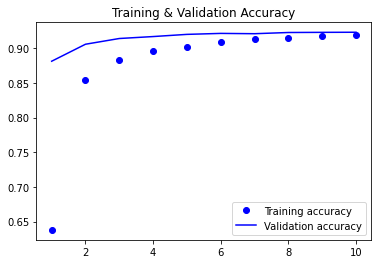

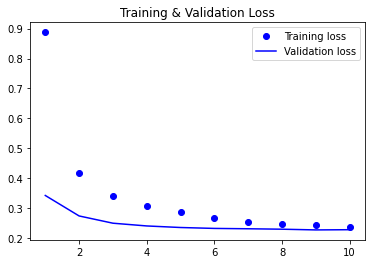

In [47]:
import matplotlib.pyplot as plt
acc = History.history['acc']
val_acc = History.history['val_acc']
loss = History.history['loss']
val_loss = History.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training accuracy')
plt.plot(epochs,val_acc,'b',label='Validation accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()
